# Gaussian Regression Colors

This notebook uses Gaussian regression to fit CSP light curves and model the evolution of observed color over time. Results are compared to the color evolution of individual models.


In [1]:
import sys

import numpy as np
import sncosmo
from matplotlib import pyplot as plt
from sndata.csp import dr3

sys.path.insert(0, '../')
from analysis import models
from analysis import lc_colors


In [2]:
# Register models and data with sncosmo
models.register_sources(force=True)
dr3.download_module_data()
dr3.register_filters(force=True)

# Load models for different masses
m102 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.02))
m104 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.04))
m14 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.4))
m17 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.7))
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))


## Transmission Filters

We review the CSP filter transmission curves and take note that there are multiple "duplicate" filters where different physical filters were used on different telescopes or a filter was broken and subsequently replaced.

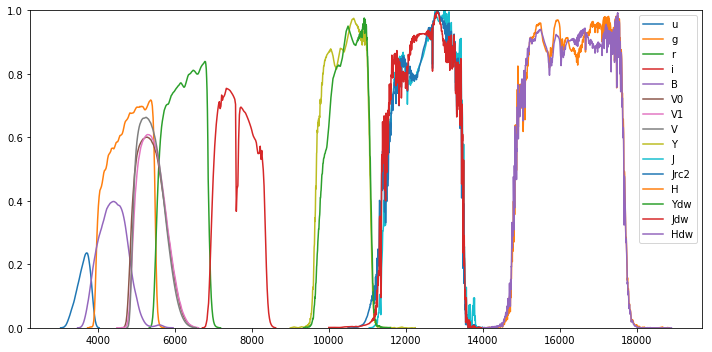

In [3]:
plt.figure(figsize=(10, 5))
for band_name in dr3.band_names:
    band = sncosmo.get_bandpass(band_name)
    band_label = band_name.split('_')[-1]
    plt.plot(band.wave, band.trans, label=band_label)

plt.legend()  
plt.ylim(0, 1)
plt.tight_layout()


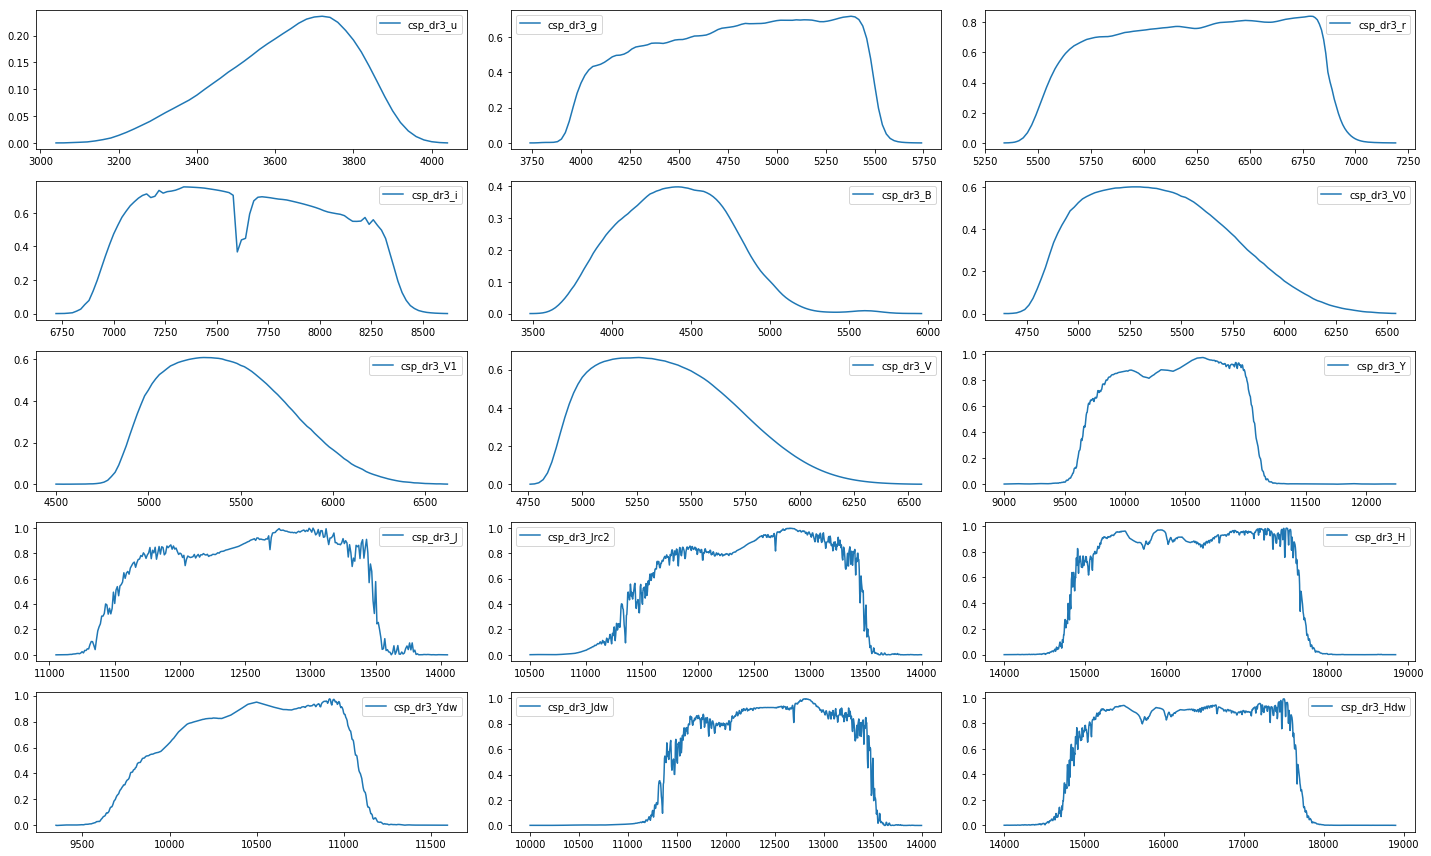

In [4]:
columns = 3
scale_factor = 4

rows = int(np.ceil(len(dr3.band_names) / columns))
fig_shape = (rows, columns)
fig_size = (scale_factor * rows, scale_factor * columns)

fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
for band_name, axis in zip(dr3.band_names, axes.flatten()):
    band = sncosmo.get_bandpass(band_name)
    axis.plot(band.wave, band.trans, label=band_name)
    axis.legend()
    
plt.tight_layout()
    

## CMFGEN Color Evolution

To develop intuition, we compare of CMFGEN color evolution against Salt2.4. We recognize that the color evolution is dependent on the salt2 model parameters. However, we only concern ourselves with a fiducial model having the default parameters. We also note that the CMFGEN models do not have any parameters that impact their color evolution.

In [48]:
def subplot_model_colors(model, band_combos, fig, axes, **kwargs):
    """Plot model colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        model                  (Model): Model to calculate color with
        band_combos (list[tuple[str]]): Band combos to calculate color for
        fig                   (Figure): Use an existing figure
        axes                   (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """
    
    axis_list = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    if len(axis_list) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    time = np.arange(model.mintime(), model.maxtime())
    t0 = model.source.peakphase('standard::b')
    for (band1, band2), axis in zip(band_combos, axis_list):
        try:
            c = model.color(band1, band2, 'ab', time)
            
        except ValueError as e:
            print(f'{model.source.name} {model.source.version}: {e}')
            pass

        else:
            label = f'{model.source.name} {model.source.version}'
            axis.plot(time - t0, c, label=label, **kwargs)
            
            y_label = f'{band1.split("_")[-1]} - {band2.split("_")[-1]}'
            axis.set_ylabel(y_label)
            axis.set_xlabel('Time')
            legend_without_duplicate_labels(axis)


def plot_model_colors(models, bands):
    """Plot model colors for a given collection of models and bandpasses
    
    Args:
        models (list[Model]): Models to calculate color with
        bands    (list[str]): Bands to calculate color for
    """
    
    band_combos = [(bands[i], bands[i + 1])for i in range(len(bands) - 1)]
    
    columns = 3
    rows = int(np.ceil(len(band_combos) / columns))
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 4 * columns)
    
    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for model in models:
        subplot_model_colors(model, band_combos, fig, axes)
        
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.tight_layout()
    return fig, axes


salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_Y' [9000, .., 12244] outside spectral range [2000, .., 9200]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2000, .., 9200]


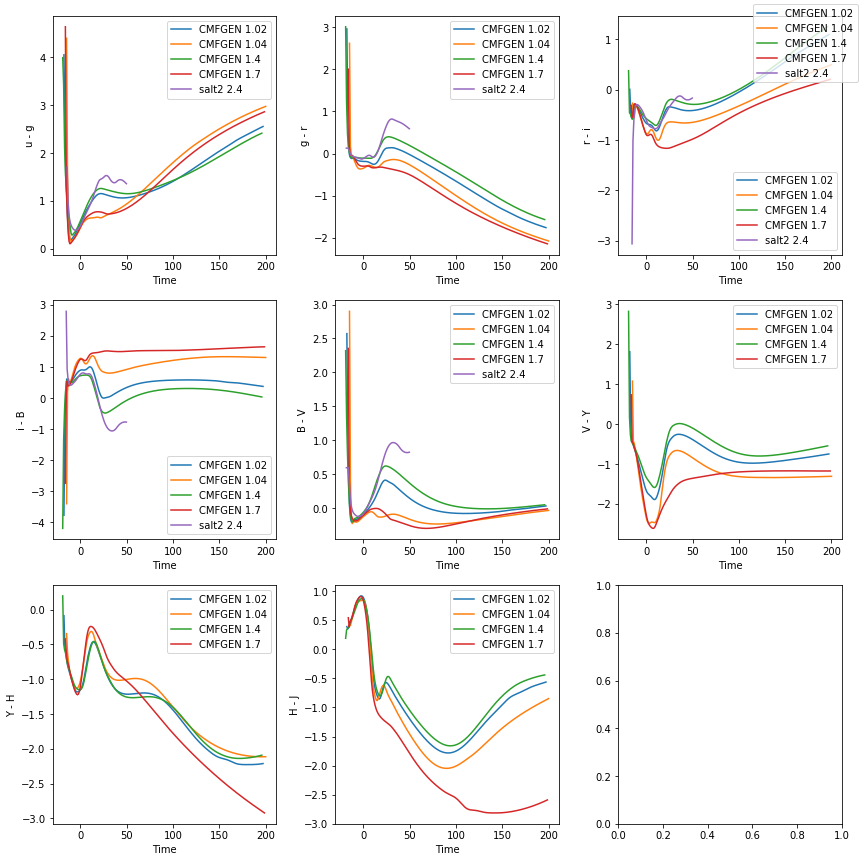

In [49]:
# A set of fiducial band passes.
unique_bands = (
    'csp_dr3_u',
    'csp_dr3_g',
    'csp_dr3_r',
    'csp_dr3_i',
    'csp_dr3_B',
    'csp_dr3_V',
    'csp_dr3_Y',
    'csp_dr3_H',
    'csp_dr3_J'
)

models = [m102, m104, m14, m17]
fig, axes = plot_model_colors(models + [salt2], unique_bands)


We emphasize there are other color combinations that are not explored here but should be since different combinations may provide different color degeneracies.

# Gaussian Regression

We use Gaussian regression to fit the light curves in each band and determine the color evolution as a function of time.


In [50]:
def plot_regression(data, times, pred_flux, pred_unc, bands):
    """Plot regression results
    
    Args:
        data            (Table): The measured photometric data
        times     (list[float]): Modeled times from the regression
        pred_flux (list[float]): Predicted flux from the regression
        pred_unc  (list[float]): Flux uncertanty from the regression
        bands       (list[str]): Bands used in the regression
    
    Returns:
        The figure object
        An array of figure axes
    """

    columns = 2
    rows = 5
    fig_shape = (rows, columns)
    fig_size = (4 * rows, 8 * columns)

    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    axes[rows - 1][0].set_xlabel('Time')
    axes[rows - 1][1].set_xlabel('Time')
    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Flux')
        
    plot_data = zip(bands, axes.flatten(), pred_flux, pred_unc)
    for band_name, axis, f, fe in plot_data:
        data_this = data[data['band'] == band_name]
        axis.scatter(data_this['time'], data_this['flux'], label=band_name)
        axis.errorbar(data_this['time'], data_this['flux'], data_this['fluxerr'], linestyle='', label=None)
        axis.plot(times, f, linestyle='--', color='black', label='Regression')
        axis.fill_between(
            times, 
            f - fe, 
            f + fe, 
            alpha=.3, 
            color='grey',
            label='Regression Err'
        )
        axis.legend()

    plt.tight_layout()
    return fig, axes


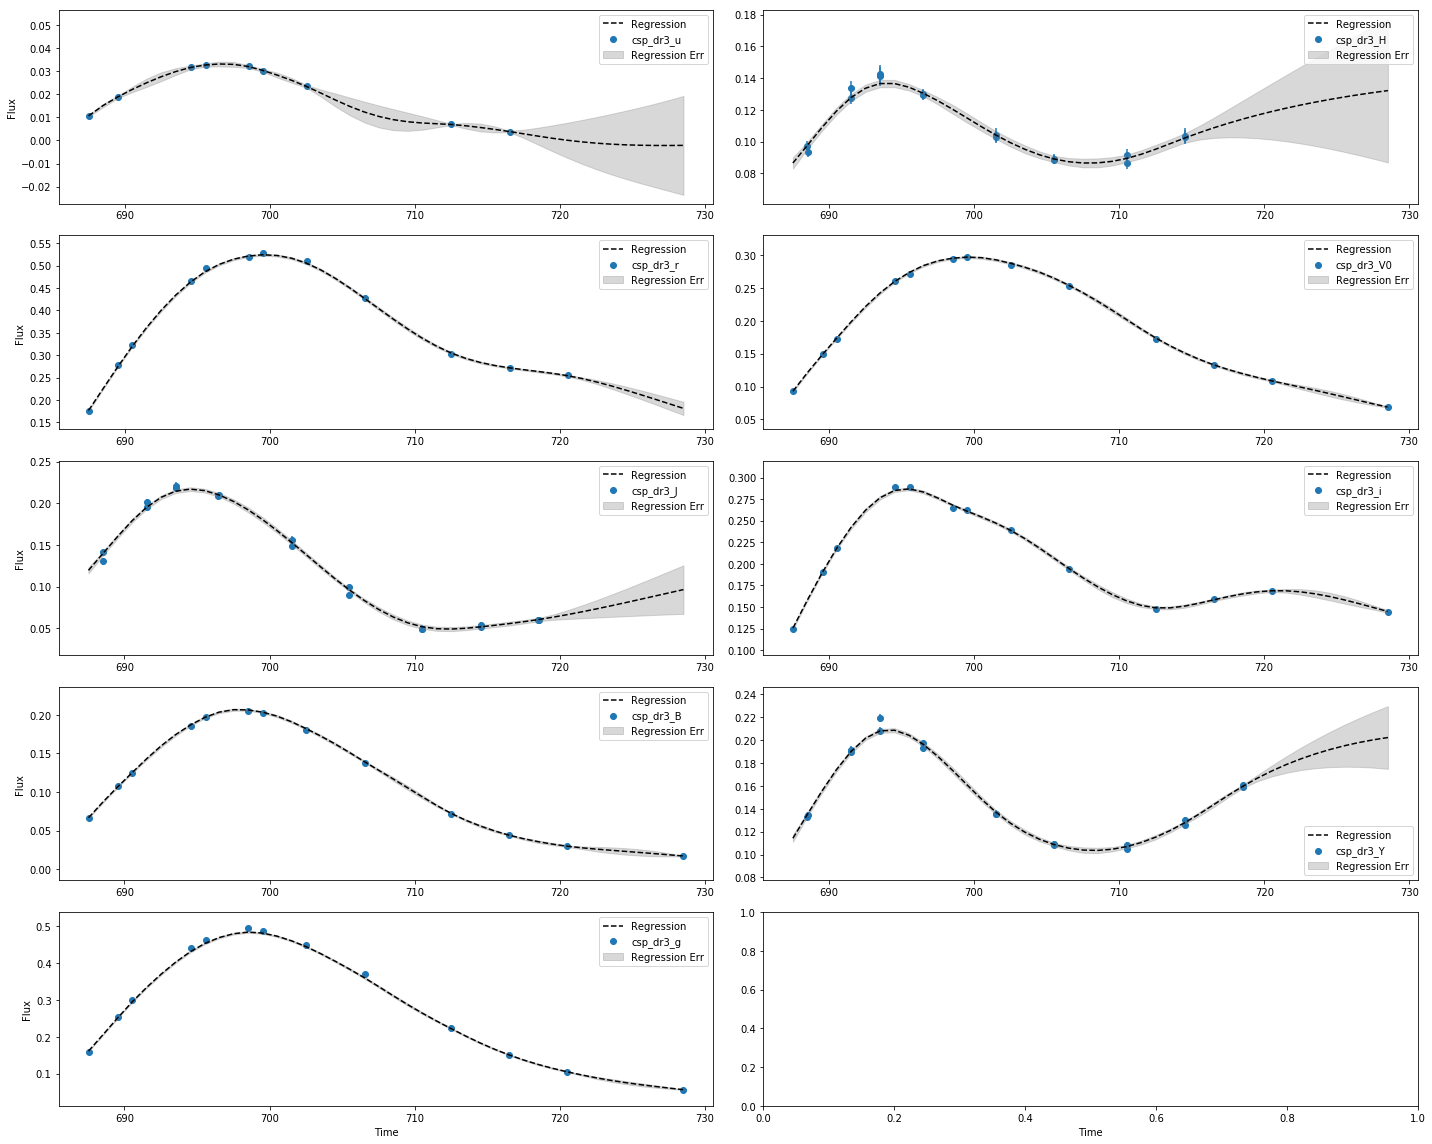

In [51]:
obj_id = '2005kc'

# Fit a gaussian regression
data_table = dr3.get_data_for_id(obj_id, format_sncosmo=True)
gp = lc_colors.fit_gaussian_process(data_table)

# Retrieve modeled flux
times = np.arange(min(data_table['time']), max(data_table['time']))
bands = set(data_table['band'])
pred_flux, pred_unc = lc_colors.predict_light_curve(gp, bands, times)

fig, axes = plot_regression(data_table, times, pred_flux, pred_unc, bands)


## Comparing Gaussian and Modeled Colors

We compare the gaussian fit color evolution against the CMFGEN models. In order to align the time scales of all results, we use the published `t0` (Salt2) value from CSP to shift the gaussian regressions to the correct t = 0 point.

In [52]:
def get_csp_t0(obj_id):
    """Get the t0 value published by CSP for a given object
    
    Args:
        obj_id (str): The object Id value
        
    Return:
        The published time of maximum minus 53000
    """

    params = dr3.load_table(3).to_pandas()
    params.set_index('SN', inplace=True)
    t0 = params.loc[obj_id]['T(Bmax)']
    if np.isnan(t0):
        raise ValueError(f'No published t0 for {obj_id}')
    
    return t0 - 53000  # Convert to CSP standard


def get_color_times(data, band_combos, delta=1):

    out_times = []
    for (band1, band2) in band_combos:
        band1_times = data[data['band'] == band1]['time']
        band2_times = data[data['band'] == band2]['time']
        
        # Skip colors not observed for the given target
        if not (bool(len(band1_times)) and bool(len(band2_times))):
            out_times.append([])
            continue
        
        start = max(min(band1_times), min(band2_times))
        end = min(max(band1_times), max(band2_times))
        out_times.append(np.arange(start, end, delta))
    
    return out_times


def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


def subplot_regression_color(data, band_combos, fig, axes, **kwargs):
    """Plot regressed colors for a given collection of bandpasses
    
    Plots are made on an existing figure
    
    Args:
        gp            (GP): A fitted gaussian process
        t0         (float): Time of B max for the fitted target
        band_combos (list): List of tuples with two bandpass names
        fig       (Figure): Use an existing figure
        axes       (array): Use existing axes
        Any other style kwargs for pyplot.plot
    """

    if len(axes.flatten()) < len(band_combos) - 1:
        raise ValueError('Not enough axes.')
    
    gp = lc_colors.fit_gaussian_process(data)
    t0 = get_csp_t0(data.meta['obj_id'])
    band_times = get_color_times(data, band_combos)
    colors, colors_var = lc_colors.predict_colors(gp, band_combos, band_times)

    plot_data = zip(band_times, colors, colors_var, axes.flatten())
    for time, color, color_var, axis in plot_data:
        axis.plot(time - t0, color, label='Regression', **kwargs)
        legend_without_duplicate_labels(axis)
        

A plot for an individual light curve.

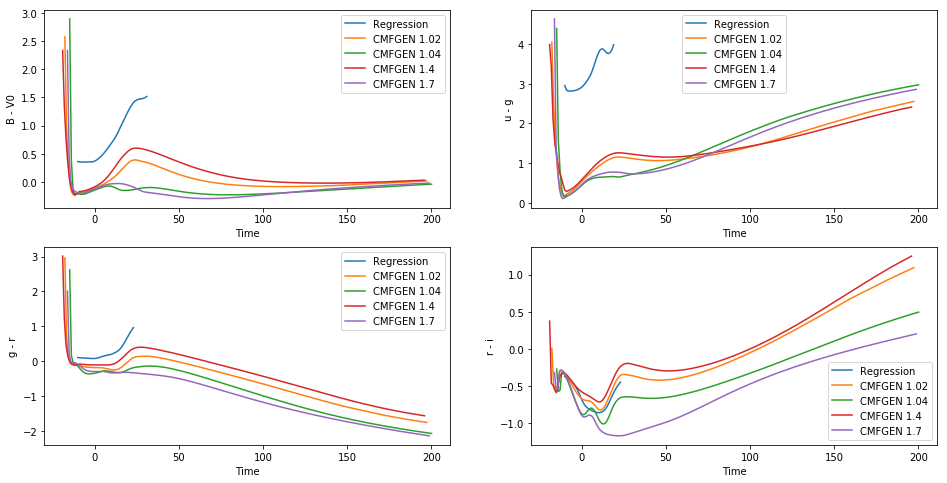

In [53]:
obj_id = '2005kc'

data = dr3.get_data_for_id(obj_id, True)
band_combos = [
    ('csp_dr3_B', 'csp_dr3_V0'), 
    ('csp_dr3_u', 'csp_dr3_g'), 
    ('csp_dr3_g', 'csp_dr3_r'), 
    ('csp_dr3_r', 'csp_dr3_i')]

fig_shape = (2, 2)
fig_size = (16, 8)
fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
subplot_regression_color(data, band_combos, fig, axes)
for model in models:
    subplot_model_colors(model, band_combos, fig, axes)


A plot for many light curves. We define a filter function that allows us to iterate over only CSP targets that have a published t0 values in DR3.

100%|██████████| 134/134 [00:22<00:00,  5.95it/s]


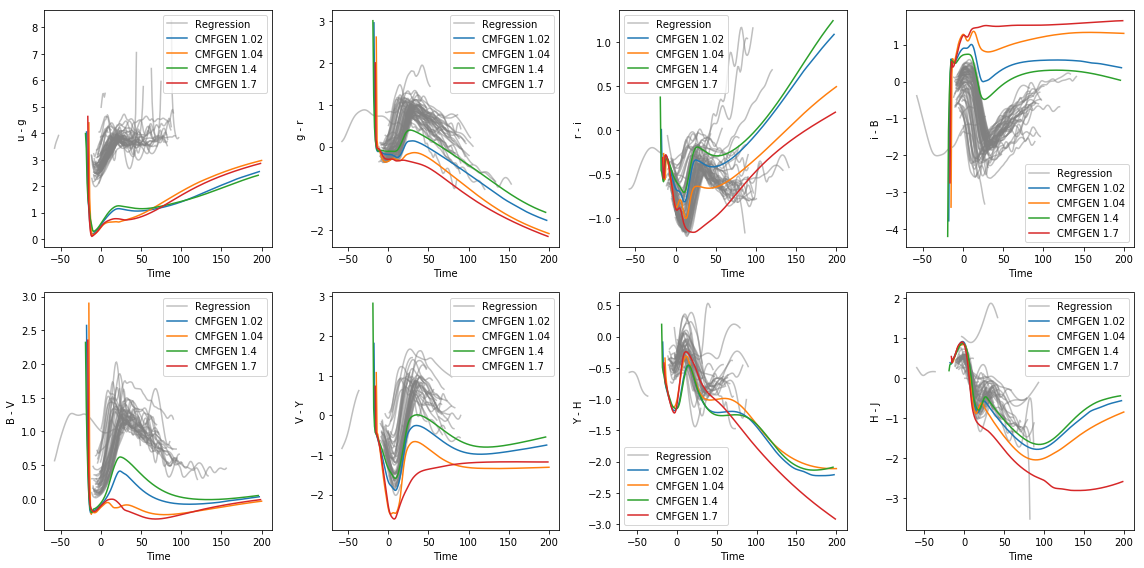

In [54]:
def filter_func(data):
    """Return whether a target has a CSP publishd t0
    
    Args:
        data (Table): An table returned by sndata
        
    Returns:
        A boolean
    """

    try:
        get_csp_t0(data.meta['obj_id'])
        return True

    except ValueError:
        return False

band_combos = [(unique_bands[i], unique_bands[i + 1]) for i in range(len(unique_bands) - 1)]
    
fig_shape = (2, 4)
fig_size = (16, 8)
fig, axes = plt.subplots(*fig_shape, figsize=fig_size)

for data_table in dr3.iter_data(filter_func=filter_func, format_sncosmo=True, verbose=True):
    subplot_regression_color(data_table, band_combos, fig, axes, color='grey', alpha=.5)

for model in models:
    subplot_model_colors(model, band_combos, fig, axes)

plt.tight_layout()


We note that there are clearly some bad regressions and that we will have to inspect individual light curves to address them.